### Setting Up Paths

The Model training pipeline was drawn from and augmented from code uploaded by Nicholas Renotte, This notebook is the experimental build of the framework

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME1 = 'ssd_mobilenet_v2_fpnlite_640_day' 
LABEL_MAP_NAME1 = 'label_map.pbtxt'

CUSTOM_MODEL_NAME2 = 'ssd_mobilenet_v2_fpnlite_640_night' 

In [3]:
paths1 = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME1), 
 }

paths2 = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME2), 
 }

In [4]:
files1 = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME1, 'pipeline.config'),
    'LABELMAP': os.path.join(paths1['ANNOTATION_PATH'], LABEL_MAP_NAME1)
}

files2 = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME2, 'pipeline.config'),
    'LABELMAP': os.path.join(paths2['ANNOTATION_PATH'], LABEL_MAP_NAME1)
}

### Label Map

In [5]:
labels = [{'name':'bicycle', 'id':1}, {'name':'bus', 'id':2}, {'name':'car', 'id':3}, {'name':'motorcycle', 'id':4}, {'name':'pedestrian', 'id':5}, {'name':'rider', 'id':6}, {'name':'train', 'id':7}, {'name':'truck', 'id':8}, {'name':'other vehicle', 'id':9}, {'name':'other person', 'id':10}, {'name':'trailer', 'id':11}]

### Config

In [6]:
import object_detection
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [7]:
config1 = config_util.get_configs_from_pipeline_file(files1['PIPELINE_CONFIG'])
config2 = config_util.get_configs_from_pipeline_file(files2['PIPELINE_CONFIG'])

### Loading Model(Checkpoint)

In [8]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [9]:
#MODEL DAY
# Load pipeline config and build a detection model
configs1 = config_util.get_configs_from_pipeline_file(files1['PIPELINE_CONFIG'])
detection_model1 = model_builder.build(model_config=configs1['model'], is_training=False)

# Restore checkpoint
ckpt1 = tf.compat.v2.train.Checkpoint(model=detection_model1)
ckpt1.restore(os.path.join(paths1['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn1(image):
    image, shapes = detection_model1.preprocess(image)
    prediction_dict = detection_model1.predict(image, shapes)
    detections = detection_model1.postprocess(prediction_dict, shapes)
    return detections

#MODEL NIGHT
# Load pipeline config and build a detection model
configs2 = config_util.get_configs_from_pipeline_file(files2['PIPELINE_CONFIG'])
detection_model2 = model_builder.build(model_config=configs2['model'], is_training=False)

# Restore checkpoint
ckpt2 = tf.compat.v2.train.Checkpoint(model=detection_model2)
ckpt2.restore(os.path.join(paths2['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn2(image):
    image, shapes = detection_model2.preprocess(image)
    prediction_dict = detection_model2.predict(image, shapes)
    detections = detection_model2.postprocess(prediction_dict, shapes)
    return detections

### Luminance Test

In [10]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(files1['LABELMAP'])
IMAGE_PATH = os.path.join(paths1['IMAGE_PATH'], 'test', '18.jpg')

In [12]:
#Calculating relative Luminance function (if fails use img.mean())
import numpy
def luminance(img):
    avg_color_per_row = numpy.average(img, axis=0)
    BGR = numpy.average(avg_color_per_row, axis=0)
    return (0.2126 * BGR[2]) + (0.7152 * BGR[1]) + (0.0722 * BGR[0])

img = cv2.imread(IMAGE_PATH)
luminance(img)

116.56644638302951

In [13]:
img.mean()

116.4240089699074

##### Testing to see the range of lumen value in dataset

In [14]:
min_lumin = lumin = cv2.imread(IMAGE_PATH).mean()
max_lumin = lumin = cv2.imread(IMAGE_PATH).mean()
for i in range(1001):
    IMAGE_PATH_TEST = os.path.join(paths1['IMAGE_PATH'], 'test', str(i) + '.jpg')
    lumin = cv2.imread(IMAGE_PATH_TEST).mean()
    if lumin < min_lumin: min_lumin = lumin
    if lumin > max_lumin: max_lumin = lumin
print('Min Lumin: ', min_lumin)
print('Max Lumin: ', max_lumin)

Min Lumin:  4.1957819733796295
Max Lumin:  170.62288990162037


NOTES

Predicted Value of lumens for levels of brightness(subjective metric, depends on personal opinion)

Bright = 91 98 92 134 92 116 116 116 111 102 = 107

Dim = 91 85 72 78 107 90 96 80 67 75 = 84

Dark = 16 13 74 22 16 44 31 56 50 53 = 37

In [15]:
IMAGE_PATH_TEST = os.path.join(paths1['IMAGE_PATH'], 'test', '0.jpg')
img_test = cv2.imread(IMAGE_PATH_TEST)
print(luminance(img_test))

91.59237493315966


### Result Gathering / Framework Test

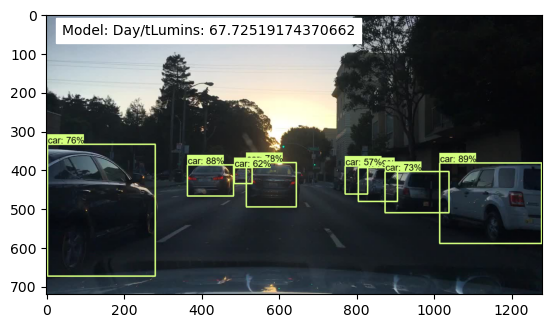

{'bicycle': 0, 'bus': 0, 'car': 8, 'motorcycle': 0, 'pedestrian': 0, 'rider': 0, 'train': 0, 'truck': 0, 'other_vehicle': 0, 'other_person': 0, 'trailer': 0}


In [16]:
#DAY MODEL
IMAGE_PATH = os.path.join(paths1['IMAGE_PATH'], 'test', '32.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

#Calculating relative Luminance according to WCAG
lumin = luminance(img)
#Upper bound of lumin, using day time model
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn1(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

#Counting no detection and no detections for each class
label_id_offset = 1
classes = {
    'bicycle':0,
    'bus':0,
    'car':0,
    'motorcycle':0,
    'pedestrian':0,
    'rider':0,
    'train':0,
    'truck':0,
    'other_vehicle':0,
    'other_person':0,
    'trailer':0
}

for i,score in enumerate(detections['detection_scores']):
    if score >= 0.5: classes[category_index[detections['detection_classes'][i] + label_id_offset]['name']] += 1
    
#Draw the bounding boxes and display model
font = cv2.FONT_HERSHEY_SIMPLEX
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1000,
        min_score_thresh=.5,
        agnostic_mode=False)

plt.text(40, 50, 'Model: Day' + '/tLumins: ' + str(lumin), backgroundcolor = 'white')
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

print(classes)

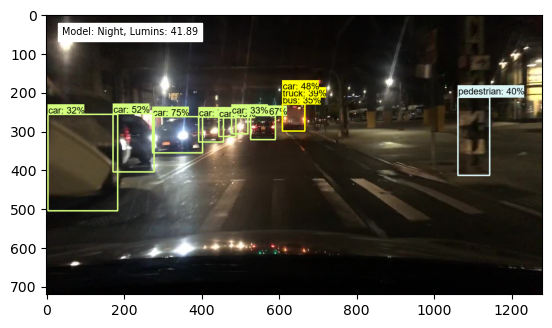

{'bicycle': 0, 'bus': 1, 'car': 8, 'motorcycle': 0, 'pedestrian': 1, 'rider': 0, 'train': 0, 'truck': 1, 'other_vehicle': 0, 'other_person': 0, 'trailer': 0}


In [17]:
#NIGHT MODEL 
#(NOTE: threshold is 0.5 instead of 0.3 to test raw performance)
IMAGE_PATH = os.path.join(paths1['IMAGE_PATH'], 'test', '109.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

#Calculating relative Luminance according to WCAG
lumin = luminance(img)
#Upper bound of lumin, using day time model
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn2(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

#Counting no detection and no detections for each class
label_id_offset = 1
classes = {
    'bicycle':0,
    'bus':0,
    'car':0,
    'motorcycle':0,
    'pedestrian':0,
    'rider':0,
    'train':0,
    'truck':0,
    'other_vehicle':0,
    'other_person':0,
    'trailer':0
}

for i,score in enumerate(detections['detection_scores']):
    if score >= 0.3: classes[category_index[detections['detection_classes'][i] + label_id_offset]['name']] += 1
    
#Draw the bounding boxes and display model
font = cv2.FONT_HERSHEY_SIMPLEX
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1000,
        min_score_thresh=.3,
        agnostic_mode=False)

plt.text(40, 50, 'Model: Night, Lumins: ' + str('{0:.2f}'.format(lumin)) , backgroundcolor = 'white', fontsize = 'x-small')
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

print(classes)

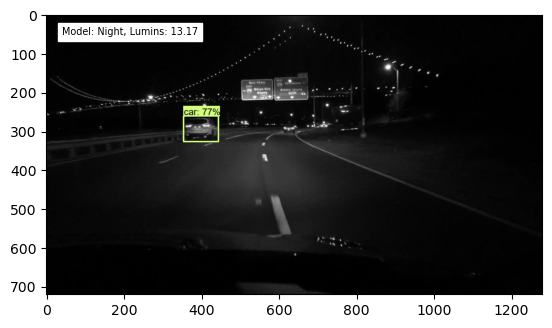

{'DateTime': ['10/06/2023 22:46:40'], 'Lumin': [13.165913628472241], 'Model': ['Day'], 'bicycle': [0], 'bus': [0], 'car': [1], 'motorcycle': [0], 'pedestrian': [0], 'rider': [0], 'train': [0], 'truck': [0], 'other_vehicle': [0], 'other_person': [0], 'trailer': [0]}


In [20]:
#FRAMEWORK
IMAGE_PATH = os.path.join(paths1['IMAGE_PATH'], 'testgrey', '2.jpg')

#Creating Master Record Dictionary
import pandas as pd
master_record = {
    'DateTime': [],
    'Lumin': [],
    'Model': [],
    'bicycle': [],
    'bus': [],
    'car': [],
    'motorcycle': [],
    'pedestrian': [],
    'rider': [],
    'train': [],
    'truck': [],
    'other_vehicle': [],
    'other_person': [],
    'trailer': []
}

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

#Calculating relative Luminance according to WCAG
lumin = luminance(img)
#Upper bound of lumin, using day time model
if lumin >= 84: 
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn1(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    #Counting no detection and no detections for each class
    label_id_offset = 1
    classes = {
        'bicycle':0,
        'bus':0,
        'car':0,
        'motorcycle':0,
        'pedestrian':0,
        'rider':0,
        'train':0,
        'truck':0,
        'other_vehicle':0,
        'other_person':0,
        'trailer':0
    }
    for i,score in enumerate(detections['detection_scores']):
        if score >= 0.5: classes[category_index[detections['detection_classes'][i] + label_id_offset]['name']] += 1
        
    #Recording date & time of detection instance
    from datetime import datetime
    date_time_instance = datetime.now()
    
    #Updating Master Record
    master_record['DateTime'].append(date_time_instance.strftime("%d/%m/%Y %H:%M:%S"))
    master_record['Lumin'].append(lumin)
    master_record['Model'].append('Day')
    for i,category in enumerate(classes.keys()):
        master_record[category].append(classes[category])
    
    #Draw the bounding boxes and display model
    font = cv2.FONT_HERSHEY_SIMPLEX
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1000,
            min_score_thresh=.5,
            agnostic_mode=False)

    plt.text(40, 50, 'Model: Day, Lumins: ' + str('{0:.2f}'.format(lumin)), backgroundcolor = 'white')
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()
    
else: 
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn2(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    #Counting no detection and no detections for each class
    label_id_offset = 1
    classes = {
        'bicycle':0,
        'bus':0,
        'car':0,
        'motorcycle':0,
        'pedestrian':0,
        'rider':0,
        'train':0,
        'truck':0,
        'other_vehicle':0,
        'other_person':0,
        'trailer':0
    }
    for i,score in enumerate(detections['detection_scores']):
        if score >= 0.3: classes[category_index[detections['detection_classes'][i] + label_id_offset]['name']] += 1
        
    #Recording date & time of detection instance
    from datetime import datetime
    date_time_instance = datetime.now()
    
    #Updating Master Record
    master_record['DateTime'].append(date_time_instance.strftime("%d/%m/%Y %H:%M:%S"))
    master_record['Lumin'].append(lumin)
    master_record['Model'].append('Day')
    for i,category in enumerate(classes.keys()):
        master_record[category].append(classes[category])
    
    #Draw the bounding boxes and display model
    font = cv2.FONT_HERSHEY_SIMPLEX
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1000,
            min_score_thresh=.3,
            agnostic_mode=False)

    plt.text(40, 50, 'Model: Night, Lumins: ' + str('{0:.2f}'.format(lumin)) , backgroundcolor = 'white', fontsize = 'x-small')
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()
    
print(master_record)

### FYP Framework

In [21]:
VIDEO_PATH = os.path.join(paths1['IMAGE_PATH'], 'BDDA_Video', 'Showcase.mp4')

In [22]:
VIDEO_PATH = os.path.join(paths1['IMAGE_PATH'], 'BDDA_Video', 'CarVid[9min].mp4')

In [22]:
print(VIDEO_PATH)

Tensorflow\workspace\images\BDDA_Video\Showcase.mp4


In [23]:
#Creating Master Record Dictionary
import pandas as pd
master_record = {
    'DateTime': [],
    'Lumin': [],
    'Model': [],
    'bicycle': [],
    'bus': [],
    'car': [],
    'motorcycle': [],
    'pedestrian': [],
    'rider': [],
    'train': [],
    'truck': [],
    'other_vehicle': [],
    'other_person': [],
    'trailer': []
}

#Video Capture(or cam source)
video = cv2.VideoCapture(VIDEO_PATH)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

while video.isOpened():
    #frame of source & numpy eqv
    ret, frame = video.read()
    image_np = np.array(frame)
    
    #Calculating relative Luminance according to WCAG
    lumin = luminance(frame)
    
    if lumin >= 84:
        #Input tensors and model detection all into 'detections' array format
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn1(input_tensor)
        
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
        detections['num_detections'] = num_detections
        
        # Detection classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        #Counting no detection and no detections for each class
        label_id_offset = 1
        classes = {
            'bicycle':0,
            'bus':0,
            'car':0,
            'motorcycle':0,
            'pedestrian':0,
            'rider':0,
            'train':0,
            'truck':0,
            'other_vehicle':0,
            'other_person':0,
            'trailer':0
        }
        for i,score in enumerate(detections['detection_scores']):
            if score >= 0.5: classes[category_index[detections['detection_classes'][i] + label_id_offset]['name']] += 1
                
        #Recording date & time of detection instance
        from datetime import datetime
        date_time_instance = datetime.now()
    
        #Updating Master Record
        master_record['DateTime'].append(date_time_instance.strftime("%d/%m/%Y %H:%M:%S"))
        master_record['Lumin'].append(lumin)
        master_record['Model'].append('Day')
        for i,category in enumerate(classes.keys()):
            master_record[category].append(classes[category])
            
        #Draw the bounding boxes and display model
        image_np_with_detections = image_np.copy()
        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1000,
            min_score_thresh=.5,
            agnostic_mode=False)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_np_with_detections,'Model: Day' + 'Lumen: ' + str(lumin),(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (1280, 720)))
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            video.release()
            cv2.destroyAllWindows()
            break
            
    else:
        #Input tensors and model detection all into 'detections' array format
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn2(input_tensor)
        
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
        detections['num_detections'] = num_detections
        
        # Detection classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        #Counting no detection and no detections for each class
        label_id_offset = 1
        classes = {
            'bicycle':0,
            'bus':0,
            'car':0,
            'motorcycle':0,
            'pedestrian':0,
            'rider':0,
            'train':0,
            'truck':0,
            'other_vehicle':0,
            'other_person':0,
            'trailer':0 

        }
        for i,score in enumerate(detections['detection_scores']):
            if score >= 0.5: classes[category_index[detections['detection_classes'][i] + label_id_offset]['name']] += 1
                
        #Recording date & time of detection instance
        from datetime import datetime
        date_time_instance = datetime.now()
    
        #Updating Master Record
        master_record['DateTime'].append(date_time_instance.strftime("%d/%m/%Y %H:%M:%S"))
        master_record['Lumin'].append(lumin)
        master_record['Model'].append('Day')
        for i,category in enumerate(classes.keys()):
            master_record[category].append(classes[category])
            
        #Draw the bounding boxes and display model
        image_np_with_detections = image_np.copy()
        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1000,
            min_score_thresh=.5,
            agnostic_mode=False)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_np_with_detections,'Model: Night ' + 'Lumen: ' + str(lumin),(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (1280, 720)))
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            video.release()
            cv2.destroyAllWindows()
            break
            
#print(master_record)
#Converting to pandas dataframe and exporting as csv
master_record = pd.DataFrame.from_dict(master_record)
master_record.to_csv('C:/Users/harit/Downloads/This sem/FYP/Code/FYP_final/Tensorflow/workspace/images/BDDA_Video/Master_Record.csv')